In [1]:
# Testing
import os
import torch
import random
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from tqdm import tqdm
from accelerate import Accelerator
from torchvision import transforms
from torchvision.transforms import Lambda
from torchvision.utils import save_image, make_grid

from ddpm import DDPM
from cnn import CNN
from utils import load_config, set_seed, frechet_distance
from plot_utils import plot_loss, plot_progress, plot_saved_grids, plot_fid
from data_loader import get_dataloaders
from utils import save_training_results
from torchvision.utils import save_image, make_grid


In [2]:
config_path = "config.yaml"

# store metrics
metrics = []
avg_train_losses = []
avg_val_losses = []
fids = []
epoch_metrics = {}

# load config
config = load_config(config_path)

# set seed
set_seed(config['hyperparameters']['seed'])

# initialise the model
gt = CNN(**config['CNN'])
ddpm = DDPM(gt = gt, **config["ddpm"])
optim = torch.optim.Adam(ddpm.parameters(), lr=float(config["optim"]["lr"]))
timesteps = config["hyperparameters"]["timesteps"]
interval = config["hyperparameters"]["interval"]

# Load the MNIST dataset
train_dataloader, test_dataloader = get_dataloaders(config["hyperparameters"]["batch_size"], 
                                    config["hyperparameters"]["num_workers"])

# get real images for FID
real_images, _ = next(iter(train_dataloader))

# prepare the device
accelerator = Accelerator()
ddpm, optim, train_dataloader, test_dataloader = accelerator.prepare(ddpm, optim, train_dataloader, test_dataloader)

# Train the model
epochs = config['hyperparameters']['epochs']

In [9]:
def train_epoch(model, dataloader, optimizer, display_interval=100, single_batch=False):
    model.train()
    train_losses = []
    pbar = tqdm(dataloader, desc='Training', total=(1 if single_batch else None))
    
    for batch_idx, (x, _) in enumerate(pbar):
        optimizer.zero_grad()
        loss, z_t = model.forward_blur(x)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_description(f"Train Loss: {np.mean(train_losses):.3g}")

        # Display images at specific intervals
        if batch_idx % display_interval == 0:
            plt.figure(figsize=(16, 8))  # Set the figure size to make the subplots larger and side by side
            
            # Original images
            plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
            gridx = make_grid(x, nrow=8)
            npimgx = gridx.cpu().numpy()
            plt.imshow(np.transpose(npimgx, (1, 2, 0)))
            plt.axis('off')
            plt.title('Original Images')

            # Transformed images
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
            grid = make_grid(z_t, nrow=8)
            npimg = grid.cpu().numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
            plt.axis('off')
            plt.title(f"Transformed Images - Batch {batch_idx}")

            plt.show()

        if single_batch:
            break  # Exit after first batch if single_batch is True
    
    avg_train_loss = np.mean(train_losses)
    return avg_train_loss, z_t, x

Train Loss: 0.463:   0%|          | 0/468 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


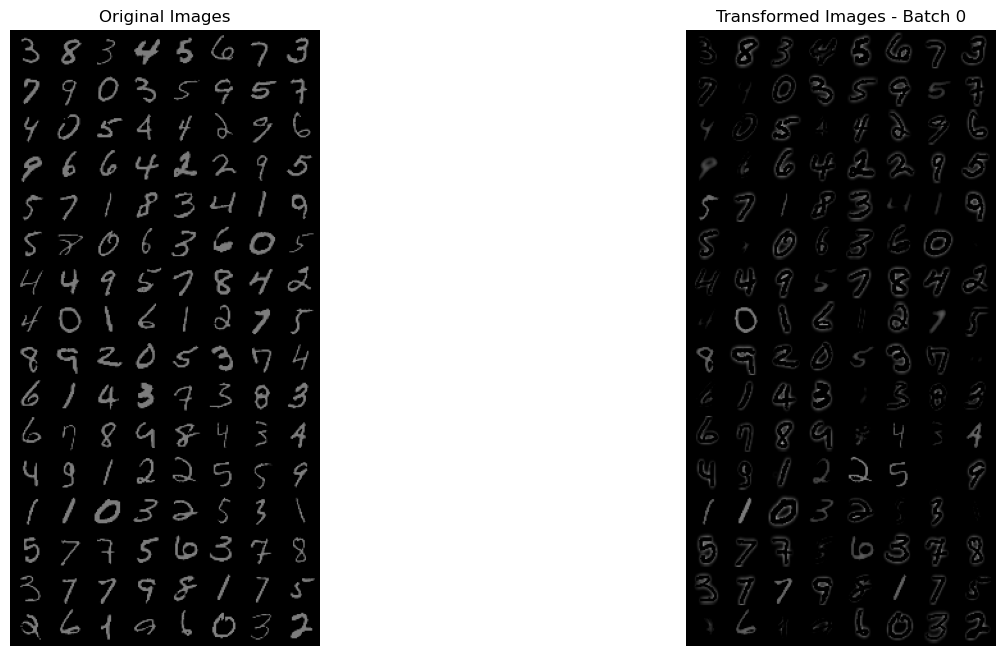

Train Loss: 0.037:  21%|██        | 98/468 [00:05<00:11, 30.91it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


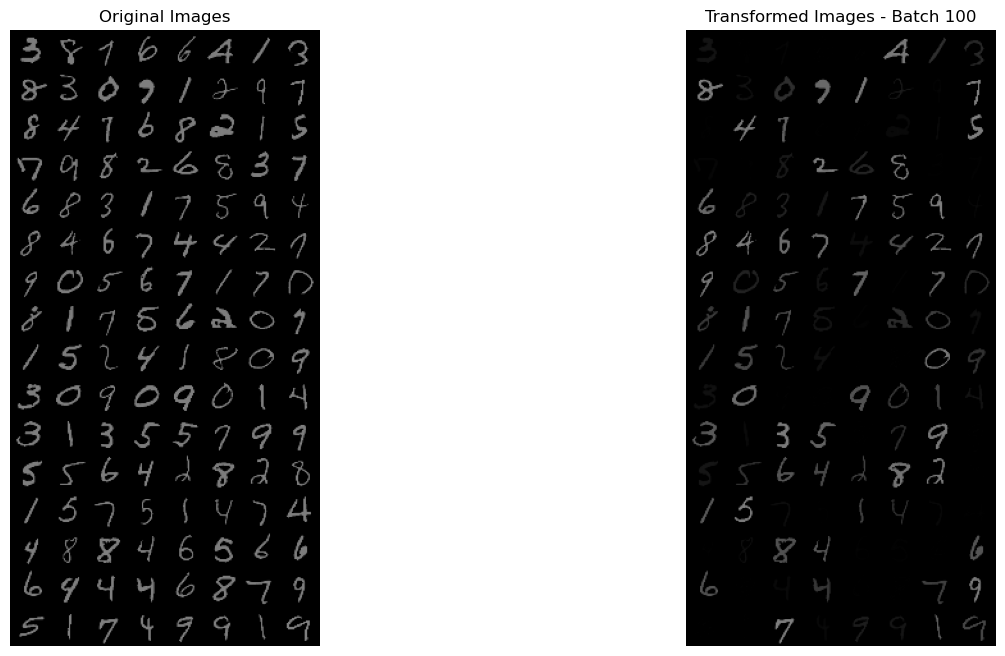

Train Loss: 0.0234:  43%|████▎     | 200/468 [00:08<00:08, 30.50it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


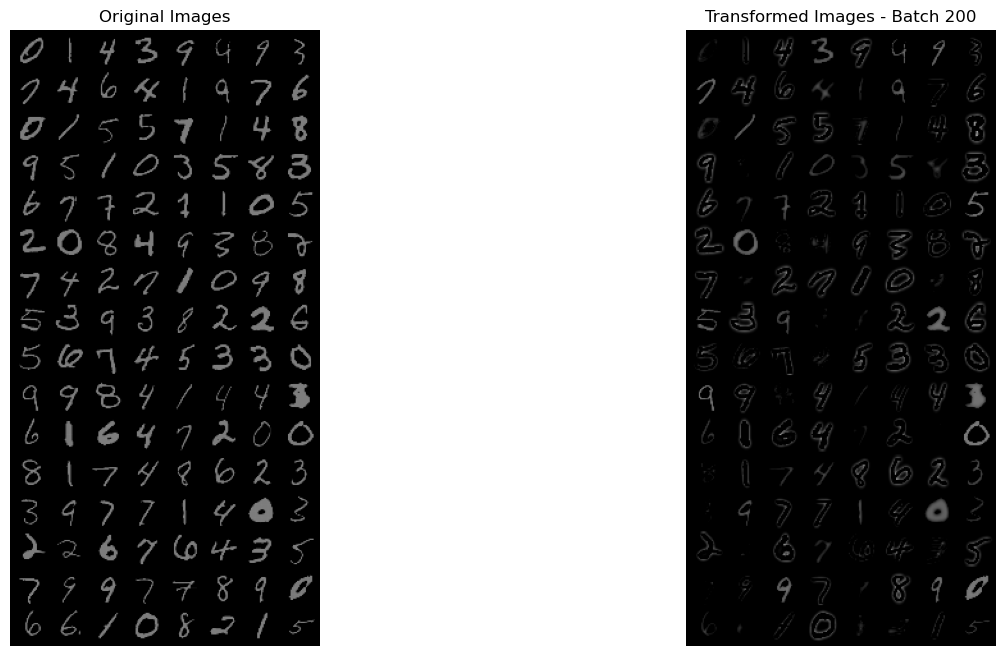

Train Loss: 0.0182:  64%|██████▍   | 299/468 [00:12<00:05, 30.78it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


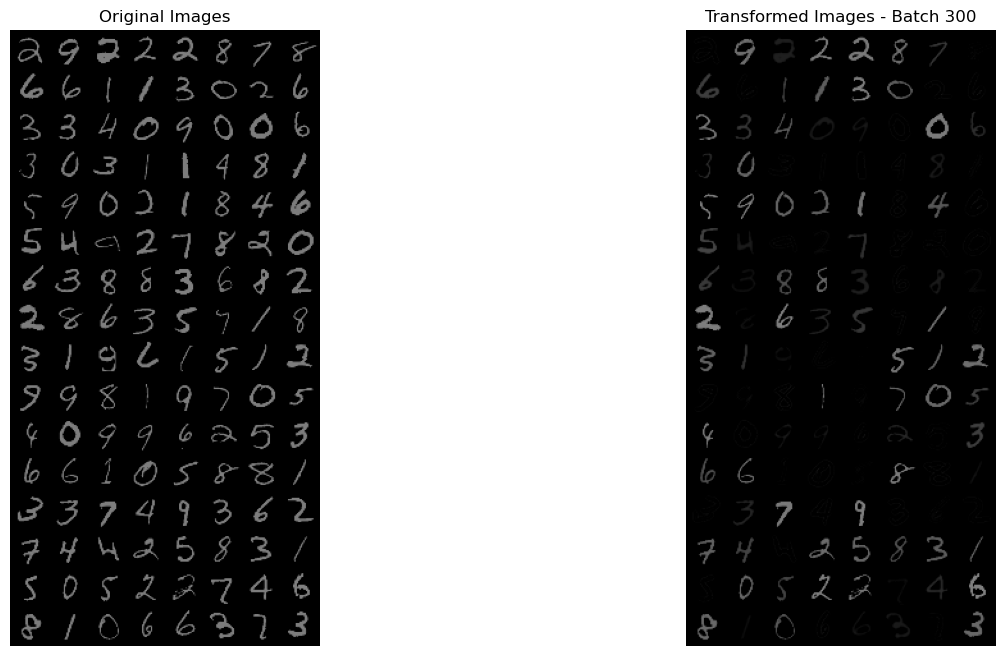

Train Loss: 0.0155:  85%|████████▌ | 398/468 [00:15<00:02, 30.91it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


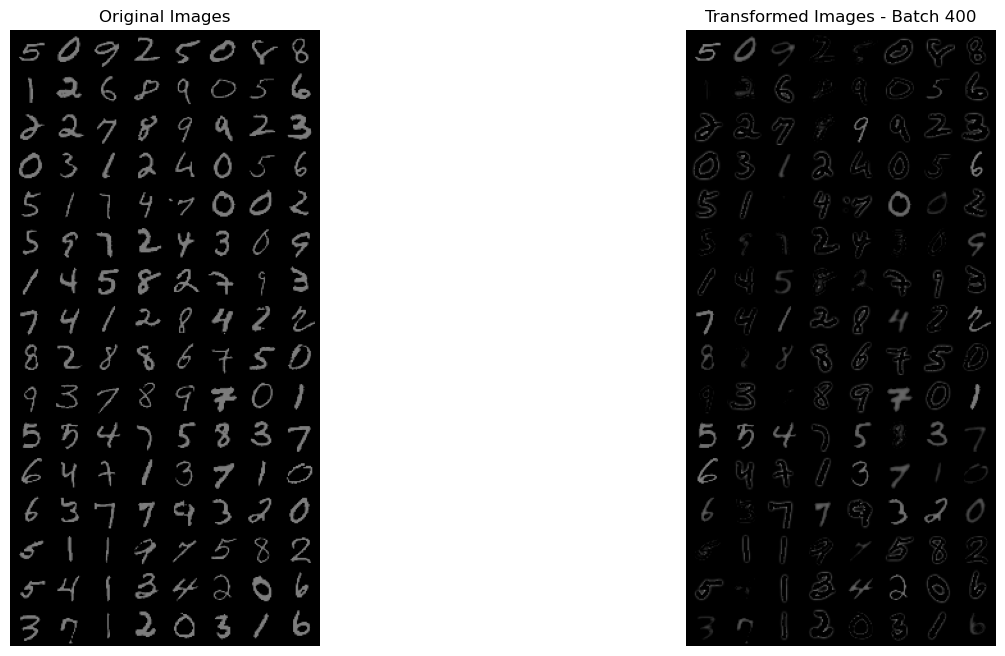

Train Loss: 0.0143: 100%|██████████| 468/468 [00:18<00:00, 25.59it/s]


In [10]:
avg_loss , z_t, x = train_epoch(ddpm, train_dataloader, optim, single_batch=False)

In [ ]:
z_t

tensor([[[[ 1.8362e-01, -9.3995e-01,  3.6182e-01,  ...,  1.1312e+00,
           -1.6231e+00,  9.4484e-02],
          [ 1.0130e-01,  1.6216e+00, -2.4820e-01,  ...,  1.8389e-01,
           -6.6959e-03,  8.4018e-01],
          [-5.5602e-04, -5.8918e-01, -2.2337e+00,  ...,  3.2027e-01,
            7.3922e-01, -2.2216e-01],
          ...,
          [-5.0552e-01, -7.2687e-01, -5.4190e-01,  ..., -4.8446e-01,
            1.6279e+00, -8.3166e-01],
          [-4.7779e-01, -9.3784e-01, -3.6963e-01,  ..., -1.6414e+00,
           -7.7873e-01,  7.6900e-01],
          [-1.0252e+00, -7.6918e-02, -1.3340e+00,  ..., -2.3025e+00,
            5.0139e-02, -9.9585e-01]]],


        [[[ 1.6862e-01, -2.1003e-01, -1.1116e+00,  ...,  1.0809e-02,
           -1.7204e+00, -5.6842e-01],
          [-4.3760e-01, -5.5769e-01, -1.3363e+00,  ..., -1.8843e+00,
            2.8527e-01,  8.0518e-01],
          [-5.4670e-01, -1.4998e+00,  1.8785e-01,  ..., -4.7162e-01,
           -1.2461e+00, -4.5894e-01],
          ...,
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


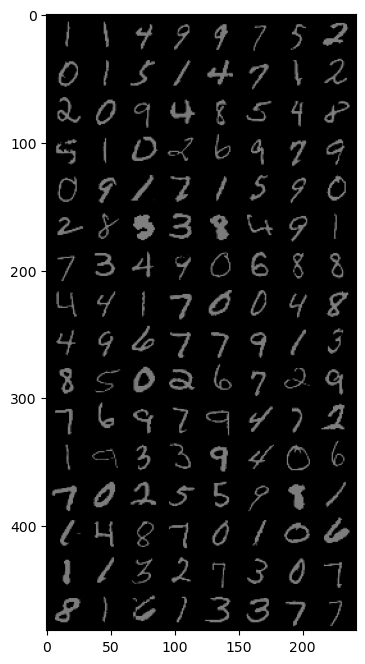

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


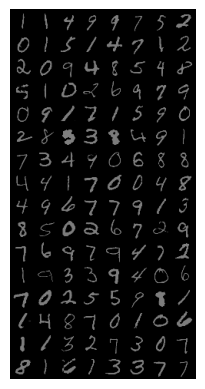

In [ ]:

from PIL import Image
from torchvision.transforms import v2

blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.0001))
blurred_imgs = blurrer(x)
blurred_imgs

grid = make_grid(blurred_imgs, nrow=8)
npimg = grid.cpu().numpy()
plt.subplots(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()


gridx = make_grid(x, nrow=8)
npimgx = gridx.cpu().numpy()
plt.imshow(np.transpose(npimgx, (1, 2, 0)))
plt.axis('off')
plt.show()